# 8.1 FGSM 공격



In [1]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms

import numpy as np
from PIL import Image
import json

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

torch.manual_seed(1)

In [3]:
CLASSES = json.load(open('./imagenet_samples/imagenet_classes.json'))
idx2class = [CLASSES[str(i)] for i in range(1000)]
class2idx = {v:i for i,v in enumerate(idx2class)}

In [4]:
vgg16 = models.vgg16(pretrained=True)
vgg16.eval()
print(vgg16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

In [5]:
softmax = torch.nn.Softmax()

In [6]:
img_transforms = transforms.Compose([transforms.Scale((224, 224), Image.BICUBIC),
                                     transforms.ToTensor(),
                                     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
def norm(x):
    return 2.*(x/255.-0.5)

def unnorm(x):
    un_x = 255*(x*0.5+0.5)
    un_x[un_x > 255] = 255
    un_x[un_x < 0] = 0
    un_x = un_x.astype(np.uint8)
    return un_x

/usr/local/lib/python3.5/dist-packages/torchvision/transforms/transforms.py:188: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  "please use transforms.Resize instead.")


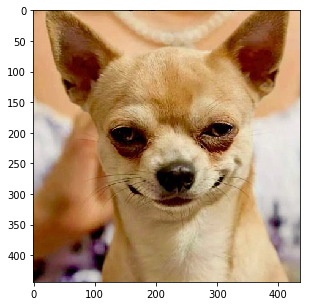

In [7]:
img = Image.open('imagenet_samples/chihuahua.jpg')
img_tensor = img_transforms(img)

plt.figure(figsize=(10,5))
plt.imshow(np.asarray(img))

In [8]:
img_tensor.requires_grad_(True)
out = vgg16(img_tensor.unsqueeze(0))
probs = softmax(out)
cls_idx = np.argmax(out.data.numpy())
print(str(cls_idx) + ":" + idx2class[cls_idx] + ":" + str(out.data.numpy()[0][cls_idx]) + ":" + str(probs.data.numpy()[0][cls_idx]))

151:Chihuahua:25.7853:0.997884


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:3: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  This is separate from the ipykernel package so we can avoid doing imports until


In [9]:
out[0,class2idx['wooden spoon']].backward()

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:20: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


643:mask:0.509557


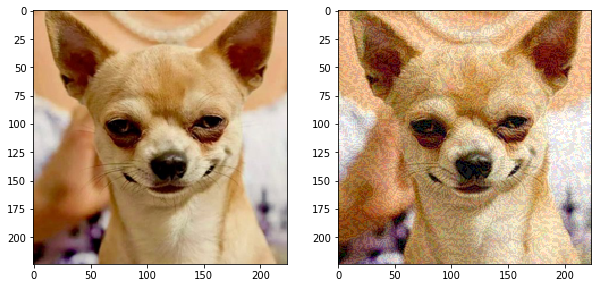

In [10]:
img_grad = img_tensor.grad
img_tensor = img_tensor.detach()

grad_sign = np.sign(img_grad.numpy()).astype(np.uint8)
epsilon = 0.1
new_img_array = np.asarray(unnorm(img_tensor.numpy()))+epsilon*grad_sign
new_img_array[new_img_array>255] = 255
new_img_array[new_img_array<0] = 0
new_img_array = new_img_array.astype(np.uint8)
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(unnorm(img_tensor.numpy()).transpose(1,2,0))
plt.subplot(1,2,2)
plt.imshow(new_img_array.transpose(1,2,0))
new_img_array = norm(new_img_array)
new_img_var = torch.FloatTensor(new_img_array)
new_img_var.requires_grad_(True)
new_out = vgg16(new_img_var.unsqueeze(0))
new_out_np = new_out.data.numpy()
new_probs = softmax(new_out)
new_cls_idx = np.argmax(new_out_np)
print(str(new_cls_idx) + ":" + idx2class[new_cls_idx] + ":" + str(new_probs.data.numpy()[0][new_cls_idx]))